In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
print(os.getcwd())


Mounted at /content/drive
/content


In [ ]:
from google.colab import files
files.upload()

!pip install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d dagnelies/deepfake-faces
!unzip -q deepfake-faces.zip -d deepfake_faces


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/dagnelies/deepfake-faces
License(s): other
 96% 416M/433M [00:00<00:00, 447MB/s]
100% 433M/433M [00:00<00:00, 516MB/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import iplot
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2

In [ ]:
meta = pd.read_csv('/content/deepfake_faces/metadata.csv')
print(meta.head())

        videoname  original_width  original_height label        original
0  aznyksihgl.mp4             129              129  FAKE  xnojggkrxt.mp4
1  gkwmalrvcj.mp4             129              129  FAKE  hqqmtxvbjj.mp4
2  lxnqzocgaq.mp4             223              217  FAKE  xjzkfqddyk.mp4
3  itsbtrrelv.mp4             186              186  FAKE  kqvepwqxfe.mp4
4  ddvgrczjno.mp4             155              155  FAKE  pluadmqqta.mp4


In [ ]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['count'] = df.count().values
    summary_df['unique'] = df.nunique().values
    summary_df['missing#'] = df.isna().sum()
    summary_df['missing%'] = df.isna().sum() / len(df)
    return summary_df

In [ ]:
print(summary(meta).style.background_gradient('Purples'))

print('Fake Images:', len(meta[meta.label=='FAKE']))
print('Real Images:', len(meta[meta.label=='REAL']))


Fake Images: 79341
Real Images: 16293


In [ ]:
# Sample balanced dataset
real_df = meta[meta['label'] == 'REAL']
fake_df = meta[meta['label'] == 'FAKE']
sample_size = 16000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [ ]:
sample_meta['filepath'] = '/content/deepfake_faces/faces_224/' + sample_meta['videoname'].str[:-4] + '.jpg'

# Split the data
Train_set, temp_df = train_test_split(sample_meta, test_size=0.2, random_state=42, stratify=sample_meta['label'])
Val_set, Test_set = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f'Train Set: {Train_set.shape}')
print(f'Validation Set: {Val_set.shape}')
print(f'Test Set: {Test_set.shape}')

Train Set: (25600, 6)
Validation Set: (3200, 6)
Test Set: (3200, 6)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [ ]:
label_map = {'REAL': 0, 'FAKE': 1}


In [ ]:
def preprocess_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    # EfficientNet expects values in [0, 255] for its preprocess function
    return image, label

# Create TensorFlow datasets
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((
    Train_set['filepath'].values,
    Train_set['label'].map(label_map).values
))
train_ds = (train_ds
           .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
           .shuffle(1000, seed=42)
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))

val_ds = tf.data.Dataset.from_tensor_slices((
    Val_set['filepath'].values,
    Val_set['label'].map(label_map).values
))
val_ds = (val_ds
         .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
         .batch(batch_size)
         .prefetch(tf.data.AUTOTUNE))

test_ds = tf.data.Dataset.from_tensor_slices((
    Test_set['filepath'].values,
    Test_set['label'].map(label_map).values
))
test_ds = (test_ds
          .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))

In [ ]:
def plot_class_counts(train_set, val_set, test_set):
    sets = ['Train Set', 'Validation Set', 'Test Set']
    colors = ['#52A666', '#C15B4E']

    y = {
        'REAL': [np.sum(train_set == 'REAL'), np.sum(val_set == 'REAL'), np.sum(test_set == 'REAL')],
        'FAKE': [np.sum(train_set == 'FAKE'), np.sum(val_set == 'FAKE'), np.sum(test_set == 'FAKE')]
    }

    trace0 = go.Bar(x=sets, y=y['REAL'], name='REAL', marker={'color': colors[0]}, opacity=0.7)
    trace1 = go.Bar(x=sets, y=y['FAKE'], name='FAKE', marker={'color': colors[1]}, opacity=0.7)

    data = [trace0, trace1]
    layout = go.Layout(title='Count of Classes in each set:', xaxis={'title': 'Set'}, yaxis={'title': 'Count'})

    fig = go.Figure(data, layout)
    iplot(fig)

plot_class_counts(np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label']))


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

from tensorflow.keras.applications import EfficientNetB4

# Build model with data augmentation
base_model = EfficientNetB4(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Create the full model with data augmentation
inputs = tf.keras.Input(shape=(224, 224, 3))

# Apply data augmentation only during training
x = data_augmentation(inputs)

# Apply EfficientNet preprocessing
x = tf.keras.applications.efficientnet.preprocess_input(x)

# Pass through base model
x = base_model(x, training=False)  # Keep base model frozen initially

# Add classification head
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Using Adam for better convergence
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 7, 7, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,793 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,675,616 (67.43 MB)

 Trainable params: 17,550,409 (66.95 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [ ]:
# Setup callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



# Model checkpoint
checkpoint_path = "/content/drive/MyDrive/NTI-PRJCT/model_epoch_{epoch:02d}.keras"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

# Early stopping with proper patience
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, checkpoint_callback, lr_reducer],
    verbose=1
)

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.7771 - loss: 0.4718
Epoch 1: saving model to /content/drive/MyDrive/NTI-PRJCT/model_epoch_01.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 717s 896ms/step - accuracy: 0.7772 - loss: 0.4718 - val_accuracy: 0.8034 - val_loss: 0.4270 - learning_rate: 0.0010
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.8216 - loss: 0.3945
Epoch 2: saving model to /content/drive/MyDrive/NTI-PRJCT/model_epoch_02.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 710s 887ms/step - accuracy: 0.8216 - loss: 0.3945 - val_accuracy: 0.8350 - val_loss: 0.3646 - learning_rate: 0.0010
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.8460 - loss: 0.3416
Epoch 3: saving model to /content/drive/MyDrive/NTI-PRJCT/model_epoch_03.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 740s 885ms/step - accuracy: 0.8460 - loss: 0.3416 - val_accuracy: 0.8519 - val_loss: 0.3786 - learning_rate: 0.0010
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy

##Training resumed here after Colab GPU reset (original run stopped at epoch 21)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(
    "/content/drive/MyDrive/Colab Notebooks/NTI-PRJCT/model_epoch_21.keras")


In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Using Adam for better convergence
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 7, 7, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,793 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,675,616 (67.43 MB)

 Trainable params: 17,550,409 (66.95 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [ ]:
!ls '/content/drive/MyDrive/Colab Notebooks/NTI-PRJCT'

model_epoch_21.keras


In [ ]:
# Setup callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



# Model checkpoint
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/NTI-PRJCT/model_epoch_{epoch:02d}.keras"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

# Early stopping with proper patience
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)
best_checkpoint_callback = ModelCheckpoint(
    filepath="/content/drive/MyDrive/Colab Notebooks/NTI-PRJCT/model_epoch_{epoch:02d}.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    initial_epoch = 21,
    callbacks=[early_stopping, checkpoint_callback,best_checkpoint_callback, lr_reducer],
    verbose=1
)

Epoch 22/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.9621 - loss: 0.0993
Epoch 22: saving model to /content/drive/MyDrive/Colab Notebooks/NTI-PRJCT/model_epoch_22.keras

Epoch 22: val_accuracy improved from -inf to 0.87531, saving model to /content/drive/MyDrive/Colab Notebooks/NTI-PRJCT/model_epoch_22.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 774s 860ms/step - accuracy: 0.9621 - loss: 0.0993 - val_accuracy: 0.8753 - val_loss: 0.3583 - learning_rate: 0.0010
Epoch 23/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.9521 - loss: 0.1238
Epoch 23: saving model to /content/drive/MyDrive/Colab Notebooks/NTI-PRJCT/model_epoch_23.keras

Epoch 23: val_accuracy did not improve from 0.87531
800/800 ━━━━━━━━━━━━━━━━━━━━ 731s 855ms/step - accuracy: 0.9521 - loss: 0.1238 - val_accuracy: 0.8712 - val_loss: 0.3874 - learning_rate: 0.0010
Epoch 24/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.9532 - loss: 0.1239
Epoch 24: saving model to /content/drive/MyDrive/Colab No

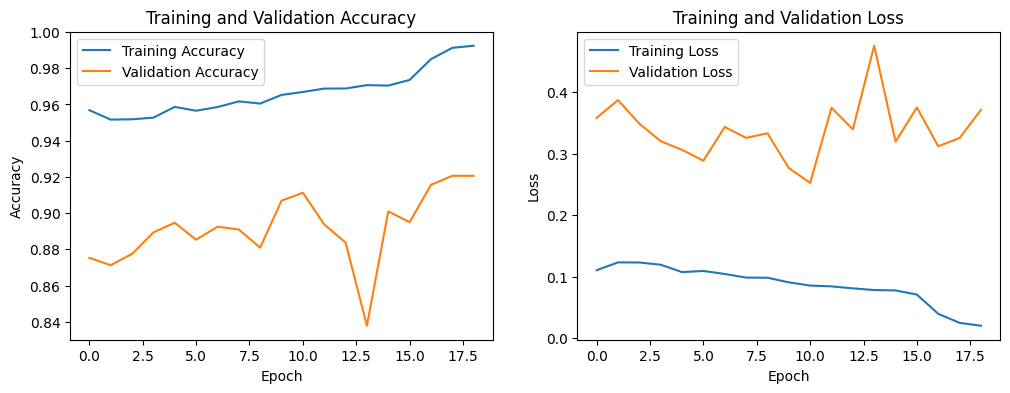

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step - accuracy: 0.9013 - loss: 0.2446
Test Loss: 0.2296
Test Accuracy: 0.9075


In [ ]:
from tensorflow.keras.models import load_model

model = load_model(
    "/content/drive/MyDrive/Colab Notebooks/NTI-PRJCT/model_epoch_32.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


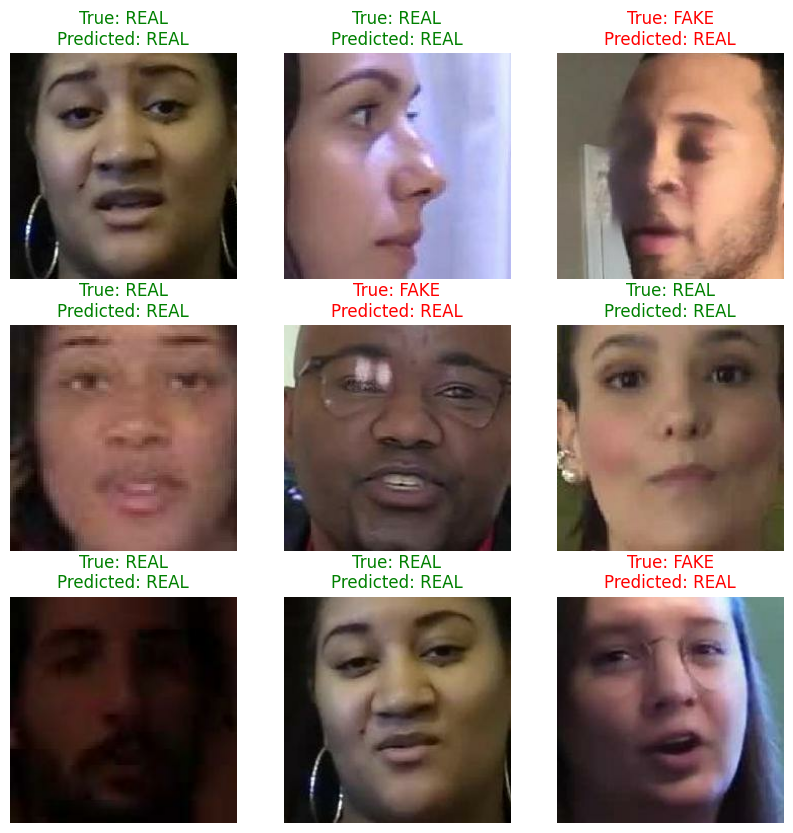

In [ ]:
for images, labels in test_ds.shuffle(buffer_size=1000, seed=None).take(1):
    break

predictions = model.predict(images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    true_label = 'REAL' if labels[i].numpy() == 0 else 'FAKE'
    predicted_label = 'REAL' if predicted_labels[i] == 0 else 'FAKE'
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)
    plt.axis("off")
plt.show()

In [ ]:
real_count = 0
fake_count = 0
for _, labels in test_ds.take(1):
    real_count += tf.reduce_sum(tf.cast(labels == 0, tf.int32)).numpy()
    fake_count += tf.reduce_sum(tf.cast(labels == 1, tf.int32)).numpy()

print(f"Number of REAL images in the first batch: {real_count}")
print(f"Number of FAKE images in the first batch: {fake_count}")

Number of REAL images in the first batch: 14
Number of FAKE images in the first batch: 18


In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 170ms/step - accuracy: 0.9013 - loss: 0.2446
Test Loss: 0.2296
Test Accuracy: 0.9075
